## calibrazione manuale

## Austria

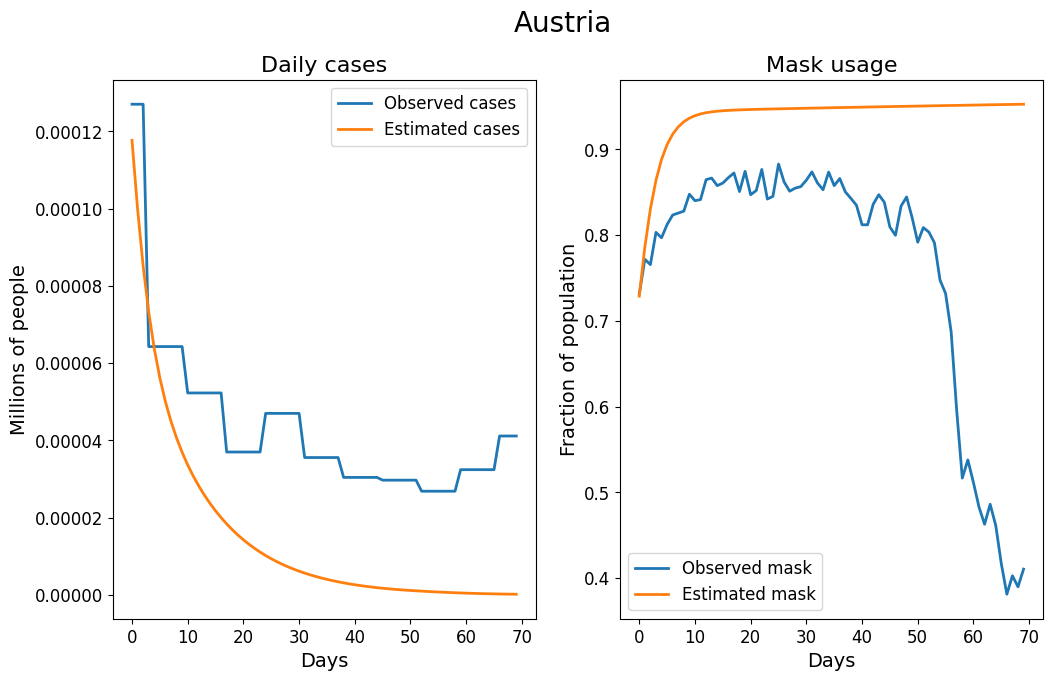

C:\Users\user\AppData\Local\Temp\ipykernel_4400\1906660377.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


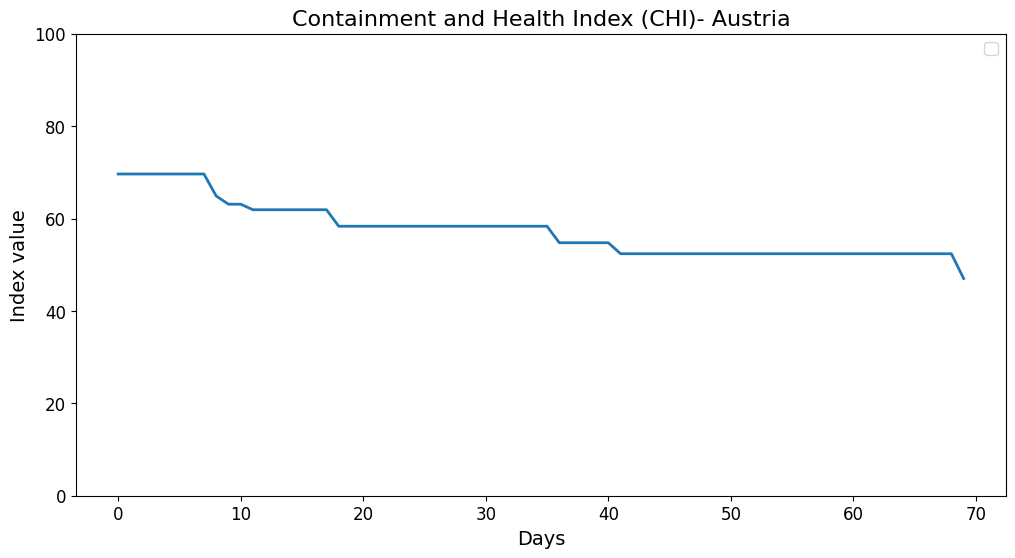

[np.float64(0.2394211764705883), np.float64(0.7232514705882352), np.float64(0.02660235294117648), np.float64(0.00046611932773109245), np.float64(1.2880672268907567e-05), np.float64(0.005123000000000026), 0.005123]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


df = pd.read_csv("csv/dati.csv")
countries = ["Austria"]
df = df[df['country'].isin(countries)]
df = df[df['survey_date'] <= '2020-07-01']
df['pct_mask_f'] = df['pct_mask'].interpolate(method='linear')  # interpolazione lineare
N = 9000000
daily_cases = df['new_cases_smoothed'].to_numpy(dtype=float) / N
mask = df['pct_mask_f'].to_numpy(dtype=float)
CHI1 = df['Facial Coverings'].fillna(0).to_numpy(dtype=float) 
CHII1 = df['Containment health index (average)'].fillna(0).to_numpy(dtype=float)
T = len(daily_cases)

# modello di RICCARDO
def modello(t, y, params):
    SH, SC, SA, IC, IA, RC, RA = y
    beta, gamma, delta, epsilon, phi, rho = params['beta'], params['gamma'], params['delta'], params['epsilon'], params['phi'], params['rho']
    k1,k2,k3,k4,k5,k6 = params['k1'],params['k2'],params['k3'],params['k4'],params['k5'],params['k6']
    l1,l2,l3,l4,l5,l6 = params['l1'],params['l2'],params['l3'],params['l4'],params['l5'],params['l6']
    psi_t = params['CHI'][min(int(t), len(params['CHI'])-1)]

    C_total = SC + IC + RC
    A_total = SA + IA + RA
    I_eff = epsilon*IC + IA

    dSH = -psi_t*k1*SH*C_total - k2*SH*A_total + l1*SC + l2*SA + delta*(1-phi)*RC - beta*SH*I_eff
    dSC = psi_t*k1*SH*C_total + delta*phi*RC - l1*SC - beta*rho*SC*I_eff
    dSA = k2*SH*A_total - l2*SA - beta*SA*I_eff + delta*RA
    dIC = beta*rho*SC*I_eff + beta*SH*I_eff + psi_t*k3*IA*C_total - l3*IC - k4*IC*A_total + l4*IA - gamma*IC
    dIA = beta*SA*I_eff - psi_t*k3*IA*C_total + l3*IC + k4*IC*A_total - l4*IA - gamma*IA
    dRC = gamma*IC - k6*RC*A_total + l6*RA + psi_t*k5*RA*C_total - l5*RC - delta*RC
    dRA = gamma*IA + k6*RC*A_total - l6*RA - psi_t*k5*RA*C_total + l5*RC - delta*RA

    return [dSH, dSC, dSA, dIC, dIA, dRC, dRA]


def simulate(params):
    SH0 = 0.989275*(1-mask[0])*0.9
    SC0 = 0.989275*mask[0]
    SA0 = 0.989275*(1-mask[0])*0.1
    IC0 = (0.000197+0.000282)*(mask[0]+(1-mask[0])*0.9)
    IA0 = (0.000197+0.000282)*(1-mask[0])*0.1
    RA0 = 0.010246/2
    RC0 = 1 - SH0 - SC0 - SA0 - IC0 - IA0 - RA0
    y0 = [SH0, SC0, SA0, IC0, IA0, RC0, RA0]

    sol = solve_ivp( lambda t, y: modello(t, y, params), (0, T - 1), y0, t_eval=np.arange(T), method="LSODA")

    SH, SC, SA, IC, IA, RC, RA = sol.y
    daily_model = params["beta"] * (IA + params["epsilon"] * IC) * (params["rho"] * SC + SA + SH)
    mask_model = SC + IC + RC
    return y0, daily_model, mask_model

# parametri scelti
params = {
    "beta": 0.3,  
    "rho": 0.2,
    "phi": 0.50,
    "gamma": 1 / 10,
    "delta": 1 / 180,
    "epsilon": 1 / 5,
    "k1": 0.2,
    "k2": 0.2,
    "l1": 0.01,
    "l2": 0.01,
    "CHI": CHI1,
    "k3": 0.2,
    "l3": 0.01,
    "k4": 0.2,
    "l4": 0.01,
    "k5": 0.2,
    "l5": 0.01,
    "k6": 0.2,
    "l6": 0.01,

}
y0, daily_model, mask_model = simulate(params)


fig, axes = plt.subplots(1, 2, figsize=(12, 7)) 

# ---- Subplot 1: Daily cases
axes[0].plot(daily_cases * N / 1e6, label="Observed cases", linewidth=2)
axes[0].plot(daily_model * N / 1e6, label="Estimated cases", linewidth=2)
axes[0].set_title("Daily cases", fontsize=16)
axes[0].set_xlabel("Days", fontsize=14)
axes[0].set_ylabel("Millions of people", fontsize=14)
axes[0].tick_params(axis="both", labelsize=12)
axes[0].legend(fontsize=12)

# ---- Subplot 2: Masks
axes[1].plot(mask, label="Observed mask", linewidth=2)
axes[1].plot(mask_model, label="Estimated mask", linewidth=2)
axes[1].set_title("Mask usage", fontsize=16)
axes[1].set_xlabel("Days", fontsize=14)
axes[1].set_ylabel("Fraction of population", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].legend(fontsize=12)

fig.suptitle("Austria", fontsize=20)
plt.savefig("C:/Users/user/Desktop/immaginitt/parte3immagini/manualeaustria.png", dpi=300, bbox_inches='tight')
plt.show()


# CHI
plt.figure(figsize=(12, 6))
plt.plot(CHII1, linewidth=2)
plt.title("Containment and Health Index (CHI)- Austria", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Index value", fontsize=14)
plt.ylim(0, 100)
plt.tick_params(axis="both", labelsize=12)
plt.legend(fontsize=12)
plt.show()
print(y0)


## Denmark

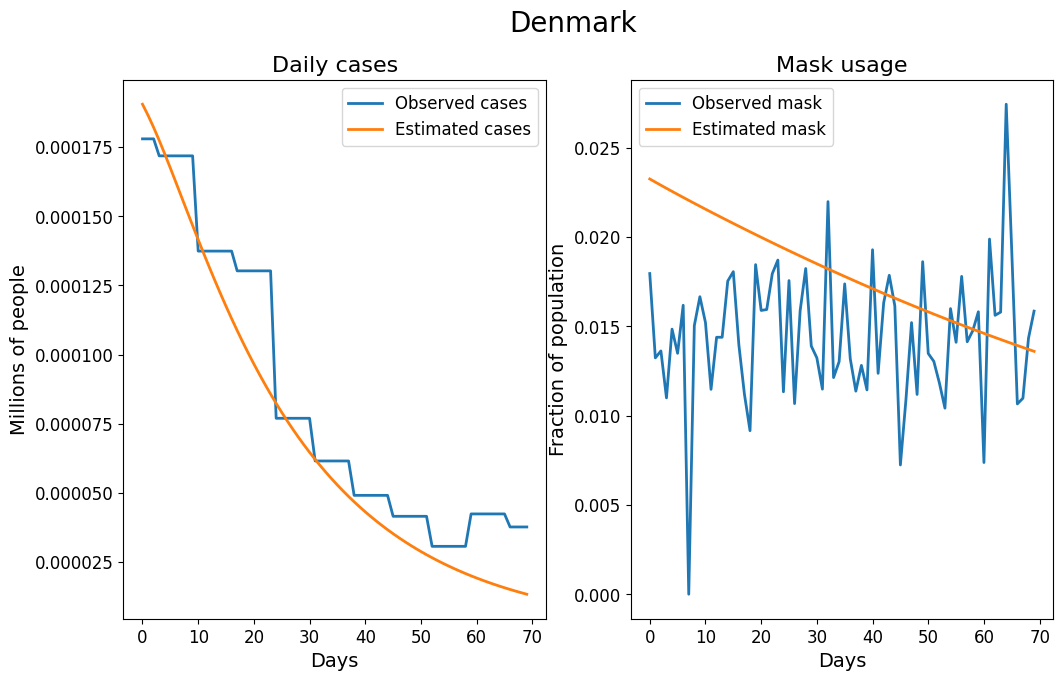

C:\Users\user\AppData\Local\Temp\ipykernel_4400\3699175209.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


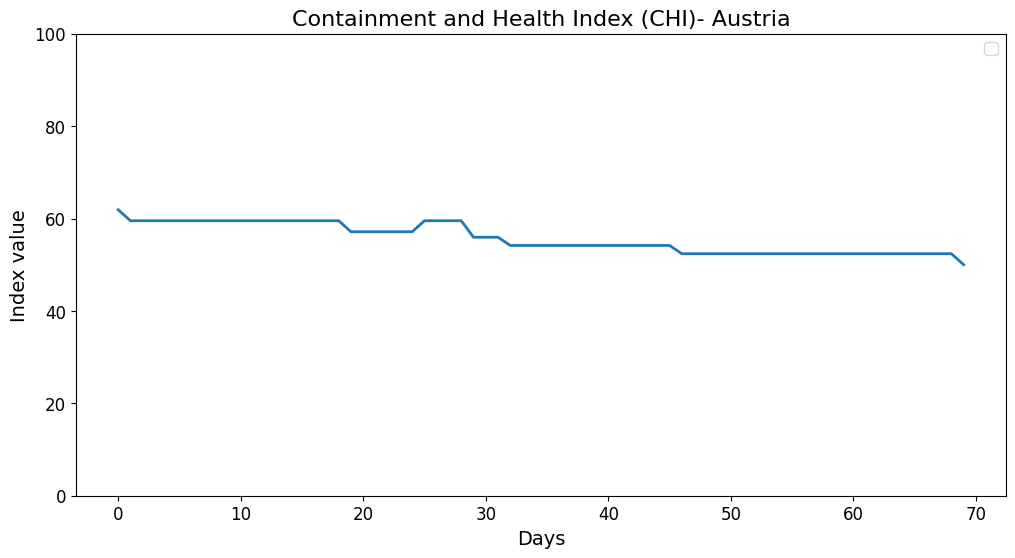

[np.float64(0.8745459089820359), np.float64(0.017775323353293387), np.float64(0.09717176766467066), np.float64(0.0005284526946107784), np.float64(5.754730538922156e-05), np.float64(0.004960500000000071), 0.0049605]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


df = pd.read_csv("csv/dati.csv")
countries = ["Denmark"]
df = df[df['country'].isin(countries)]
df = df[df['survey_date'] <= '2020-07-01']
df['pct_mask_f'] = df['pct_mask'].interpolate(method='linear')  # interpolazione lineare
N =6000000
daily_cases = df['new_cases_smoothed'].to_numpy(dtype=float) / N
mask = df['pct_mask_f'].to_numpy(dtype=float)
CHI2 = df['Facial Coverings'].fillna(0).to_numpy(dtype=float)
CHII2 = df['Containment health index (average)'].fillna(0).to_numpy(dtype=float)
T = len(daily_cases)

# modello di RICCARDO
def modello(t, y, params):
    SH, SC, SA, IC, IA, RC, RA = y
    beta, gamma, delta, epsilon, phi, rho = params['beta'], params['gamma'], params['delta'], params['epsilon'], params['phi'], params['rho']
    k1,k2,k3,k4,k5,k6 = params['k1'],params['k2'],params['k3'],params['k4'],params['k5'],params['k6']
    l1,l2,l3,l4,l5,l6 = params['l1'],params['l2'],params['l3'],params['l4'],params['l5'],params['l6']
    psi_t = params['CHI'][min(int(t), len(params['CHI'])-1)]

    C_total = SC + IC + RC
    A_total = SA + IA + RA
    I_eff = epsilon*IC + IA

    dSH = -psi_t*k1*SH*C_total - k2*SH*A_total + l1*SC + l2*SA + delta*(1-phi)*RC - beta*SH*I_eff
    dSC = psi_t*k1*SH*C_total + delta*phi*RC - l1*SC - beta*rho*SC*I_eff
    dSA = k2*SH*A_total - l2*SA - beta*SA*I_eff + delta*RA
    dIC = beta*rho*SC*I_eff + beta*SH*I_eff + psi_t*k3*IA*C_total - l3*IC - k4*IC*A_total + l4*IA - gamma*IC
    dIA = beta*SA*I_eff - psi_t*k3*IA*C_total + l3*IC + k4*IC*A_total - l4*IA - gamma*IA
    dRC = gamma*IC - k6*RC*A_total + l6*RA + psi_t*k5*RA*C_total - l5*RC - delta*RC
    dRA = gamma*IA + k6*RC*A_total - l6*RA - psi_t*k5*RA*C_total + l5*RC - delta*RA

    return [dSH, dSC, dSA, dIC, dIA, dRC, dRA]


def simulate(params):
    SH0 = 0.989493*(1-mask[0])*0.9
    SC0 = 0.989493*mask[0]
    SA0 = 0.989493*(1-mask[0])*0.1
    IC0 = (0.000352+0.000234)*(mask[0]+(1-mask[0])*0.9)
    IA0 = (0.000352+0.000234)*(1-mask[0])*0.1
    RA0 = 0.009921/2
    RC0 = 1 - SH0 - SC0 - SA0 - IC0 - IA0 - RA0
    y0 = [SH0, SC0, SA0, IC0, IA0, RC0, RA0]

    sol = solve_ivp( lambda t, y: modello(t, y, params), (0, T - 1), y0, t_eval=np.arange(T), method="LSODA")

    SH, SC, SA, IC, IA, RC, RA = sol.y
    daily_model = params["beta"] * (IA + params["epsilon"] * IC) * (params["rho"] * SC + SA + SH)
    mask_model = SC + IC + RC
    return y0, daily_model, mask_model

# parametri scelti
params = {
    "beta": 0.2, 
    "rho": 0.05,
    "phi": 0.50,
    "gamma": 1 / 10,
    "delta": 1 / 180,
    "epsilon": 1 / 5,
    "k1": 0.3,
    "k2": 0.1,
    "l1": 0.01,
    "l2": 0.2,
    "CHI": CHI2,
    "k3": 0.02,
    "l3": 0.01,
    "k4": 0.01,
    "l4": 0.01,
    "k5": 0.02,
    "l5": 0.01,
    "k6": 0.02,
    "l6": 0.01

}
y0, daily_model, mask_model = simulate(params)




fig, axes = plt.subplots(1, 2, figsize=(12, 7)) 

# ---- Subplot 1: Daily cases
axes[0].plot(daily_cases * N / 1e6, label="Observed cases", linewidth=2)
axes[0].plot(daily_model * N / 1e6, label="Estimated cases", linewidth=2)
axes[0].set_title("Daily cases", fontsize=16)
axes[0].set_xlabel("Days", fontsize=14)
axes[0].set_ylabel("Millions of people", fontsize=14)
axes[0].tick_params(axis="both", labelsize=12)
axes[0].legend(fontsize=12)

# ---- Subplot 2: Masks
axes[1].plot(mask, label="Observed mask", linewidth=2)
axes[1].plot(mask_model, label="Estimated mask", linewidth=2)
axes[1].set_title("Mask usage", fontsize=16)
axes[1].set_xlabel("Days", fontsize=14)
axes[1].set_ylabel("Fraction of population", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].legend(fontsize=12)

fig.suptitle("Denmark", fontsize=20)
plt.savefig("C:/Users/user/Desktop/immaginitt/parte3immagini/manualedenmark.png", dpi=300, bbox_inches='tight')

plt.show()


# CHI
plt.figure(figsize=(12, 6))
plt.plot(CHII2, linewidth=2)
plt.title("Containment and Health Index (CHI)- Austria", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Index value", fontsize=14)
plt.ylim(0, 100)
plt.tick_params(axis="both", labelsize=12)
plt.legend(fontsize=12)
plt.show()
print(y0)


## Switzerland

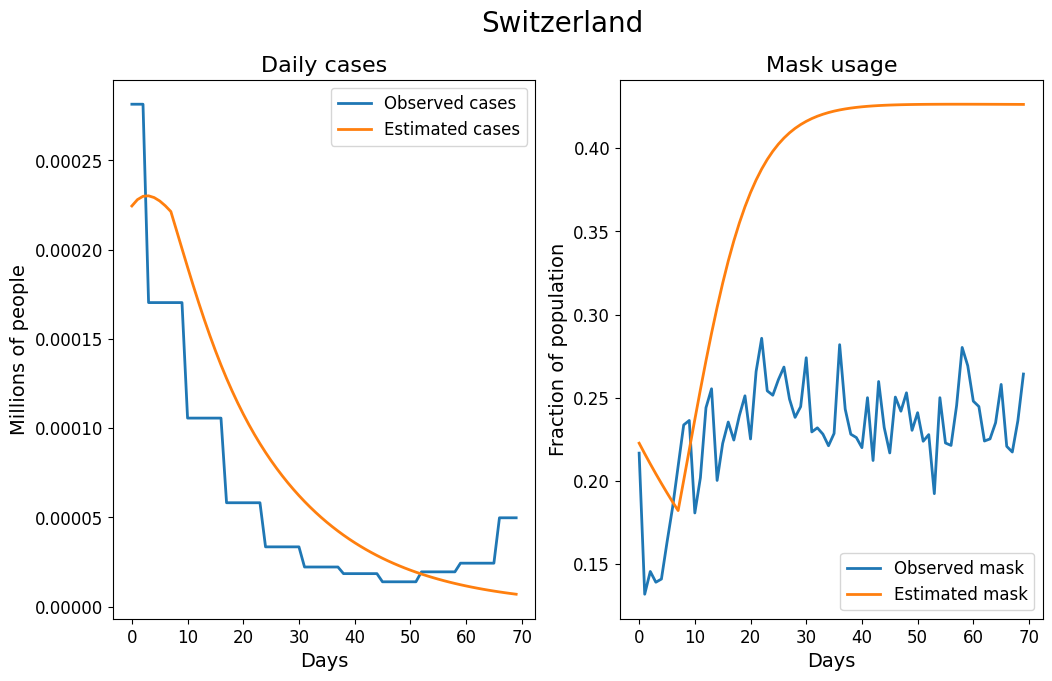

C:\Users\user\AppData\Local\Temp\ipykernel_4400\2700594450.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


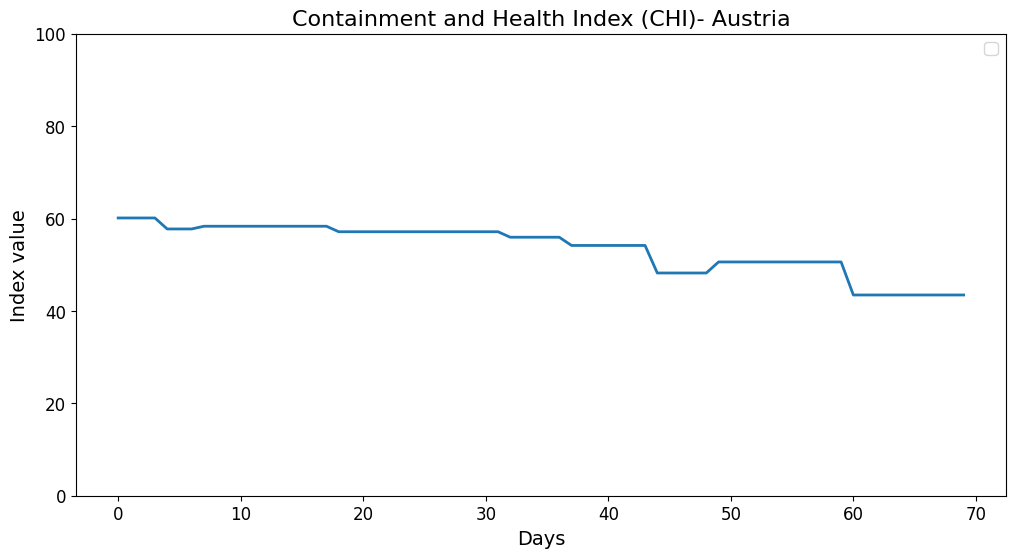

[np.float64(0.6914611800000001), np.float64(0.21250579999999994), np.float64(0.07682902000000003), np.float64(0.0011926366666666667), np.float64(0.00010136333333333336), np.float64(0.008954999999999916), 0.008955]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


df = pd.read_csv("csv/dati.csv")
countries = ["Switzerland"]
df = df[df['country'].isin(countries)]
df = df[df['survey_date'] <= '2020-07-01']
df['pct_mask_f'] = df['pct_mask'].interpolate(method='linear')  # interpolazione lineare
N = 8500000
daily_cases = df['new_cases_smoothed'].to_numpy(dtype=float) / N
mask = df['pct_mask_f'].to_numpy(dtype=float)
CHI3 = df['Facial Coverings'].fillna(0).to_numpy(dtype=float) # è sempre maggiore di 1
CHII3 = df['Containment health index (average)'].fillna(0).to_numpy(dtype=float)
T = len(daily_cases)

# modello di RICCARDO
def modello(t, y, params):
    SH, SC, SA, IC, IA, RC, RA = y
    beta, gamma, delta, epsilon, phi, rho = params['beta'], params['gamma'], params['delta'], params['epsilon'], params['phi'], params['rho']
    k1,k2,k3,k4,k5,k6 = params['k1'],params['k2'],params['k3'],params['k4'],params['k5'],params['k6']
    l1,l2,l3,l4,l5,l6 = params['l1'],params['l2'],params['l3'],params['l4'],params['l5'],params['l6']
    psi_t = params['CHI'][min(int(t), len(params['CHI'])-1)]

    C_total = SC + IC + RC
    A_total = SA + IA + RA
    I_eff = epsilon*IC + IA

    dSH = -psi_t*k1*SH*C_total - k2*SH*A_total + l1*SC + l2*SA + delta*(1-phi)*RC - beta*SH*I_eff
    dSC = psi_t*k1*SH*C_total + delta*phi*RC - l1*SC - beta*rho*SC*I_eff
    dSA = k2*SH*A_total - l2*SA - beta*SA*I_eff + delta*RA
    dIC = beta*rho*SC*I_eff + beta*SH*I_eff + psi_t*k3*IA*C_total - l3*IC - k4*IC*A_total + l4*IA - gamma*IC
    dIA = beta*SA*I_eff - psi_t*k3*IA*C_total + l3*IC + k4*IC*A_total - l4*IA - gamma*IA
    dRC = gamma*IC - k6*RC*A_total + l6*RA + psi_t*k5*RA*C_total - l5*RC - delta*RC
    dRA = gamma*IA + k6*RC*A_total - l6*RA - psi_t*k5*RA*C_total + l5*RC - delta*RA

    return [dSH, dSC, dSA, dIC, dIA, dRC, dRA]


def simulate(params):
    SH0 = 0.980796*(1-mask[0])*0.9
    SC0 = 0.980796*mask[0]
    SA0 = 0.980796*(1-mask[0])*0.1
    IC0 = (0.000773+0.000521)*(mask[0]+(1-mask[0])*0.9)
    IA0 = (0.000773+0.000521)*(1-mask[0])*0.1
    RA0 = 0.017910/2
    RC0 = 1 - SH0 - SC0 - SA0 - IC0 - IA0 - RA0
    y0 = [SH0, SC0, SA0, IC0, IA0, RC0, RA0]

    sol = solve_ivp( lambda t, y: modello(t, y, params), (0, T - 1), y0, t_eval=np.arange(T), method="LSODA")

    SH, SC, SA, IC, IA, RC, RA = sol.y
    daily_model = params["beta"] * (IA + params["epsilon"] * IC) * (params["rho"] * SC + SA + SH)
    mask_model = SC + IC + RC
    return y0, daily_model, mask_model

# parametri scelti
params = {
    "beta": 0.1,
    "rho": 0.04,
    "phi": 0.50,
    "gamma": 1 / 10,
    "delta": 1 / 180,
    "epsilon": 1 / 5,
    "k1": 0.2,
    "k2": 0.2,
    "l1": 0.03,
    "l2": 0.03,
    "CHI": CHI3,
    "k3": 0.04,
    "l3": 0.03,
    "k4": 0.04,
    "l4": 0.01,
    "k5": 0.01,
    "l5": 0.01,
    "k6": 0.01,
    "l6": 0.01

}
y0, daily_model, mask_model = simulate(params)


fig, axes = plt.subplots(1, 2, figsize=(12, 7)) 

# ---- Subplot 1: Daily cases
axes[0].plot(daily_cases * N / 1e6, label="Observed cases", linewidth=2)
axes[0].plot(daily_model * N / 1e6, label="Estimated cases", linewidth=2)
axes[0].set_title("Daily cases", fontsize=16)
axes[0].set_xlabel("Days", fontsize=14)
axes[0].set_ylabel("Millions of people", fontsize=14)
axes[0].tick_params(axis="both", labelsize=12)
axes[0].legend(fontsize=12)

# ---- Subplot 2: Masks
axes[1].plot(mask, label="Observed mask", linewidth=2)
axes[1].plot(mask_model, label="Estimated mask", linewidth=2)
axes[1].set_title("Mask usage", fontsize=16)
axes[1].set_xlabel("Days", fontsize=14)
axes[1].set_ylabel("Fraction of population", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].legend(fontsize=12)

fig.suptitle("Switzerland", fontsize=20)
plt.savefig("C:/Users/user/Desktop/immaginitt/parte3immagini/manualeswitzerland.png", dpi=300, bbox_inches='tight')

plt.show()


# CHI
plt.figure(figsize=(12, 6))
plt.plot(CHII3, linewidth=2)
plt.title("Containment and Health Index (CHI)- Austria", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Index value", fontsize=14)
plt.ylim(0, 100)
plt.tick_params(axis="both", labelsize=12)
plt.legend(fontsize=12)
plt.show()
print(y0)

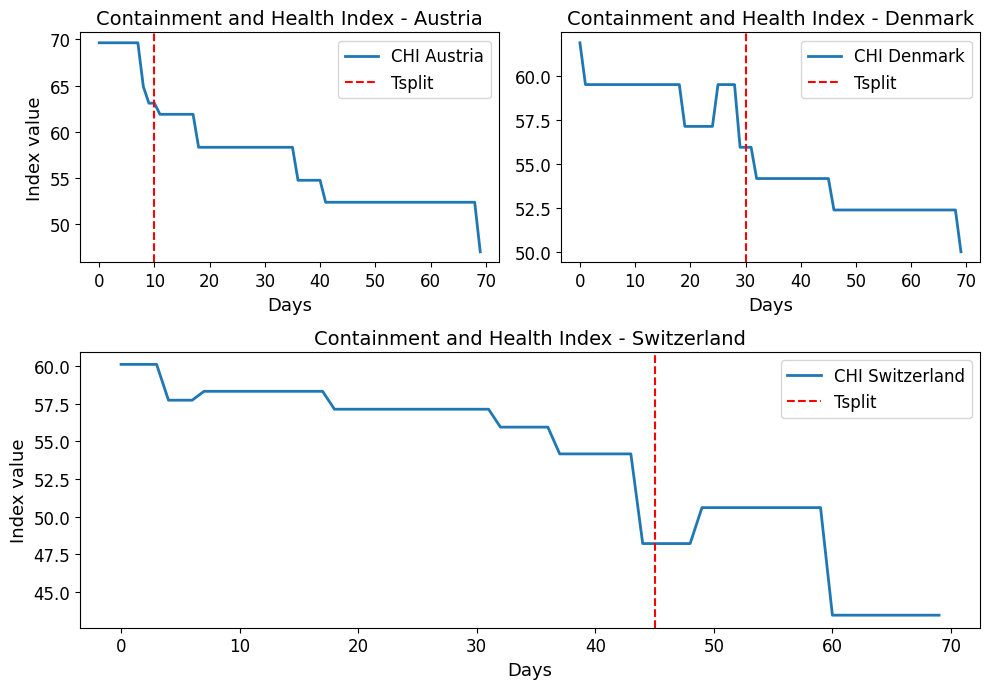

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Tsplit values
Tsplit_Austria = 10  
Tsplit_Denmark = 30  
Tsplit_Switzerland = 45   

fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])

# Austria 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(CHII1, linewidth=2, label="CHI Austria")
ax1.axvline(x=Tsplit_Austria, color="red", linestyle="--", label="Tsplit")
ax1.set_title("Containment and Health Index - Austria", fontsize=14)
ax1.set_xlabel("Days", fontsize=13)
ax1.set_ylabel("Index value", fontsize=13)
ax1.tick_params(axis="both", labelsize=12)
ax1.legend(fontsize=12)

# Denmark 
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(CHII2, linewidth=2, label="CHI Denmark")
ax2.axvline(x=Tsplit_Denmark, color="red", linestyle="--", label="Tsplit")
ax2.set_title("Containment and Health Index - Denmark", fontsize=14)
ax2.set_xlabel("Days", fontsize=13)
ax2.tick_params(axis="both", labelsize=12)
ax2.legend(fontsize=12)

# Switzerland 
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(CHII3, linewidth=2, label="CHI Switzerland")
ax3.axvline(x=Tsplit_Switzerland, color="red", linestyle="--", label="Tsplit")
ax3.set_title("Containment and Health Index - Switzerland", fontsize=14)
ax3.set_xlabel("Days", fontsize=13)
ax3.set_ylabel("Index value", fontsize=13)
ax3.tick_params(axis="both", labelsize=12)
ax3.legend(fontsize=12)

plt.tight_layout()
plt.savefig("C:/Users/user/Desktop/immaginitt/parte3immagini/CHITOTALETUTTI.png", dpi=300, bbox_inches='tight')
plt.show()


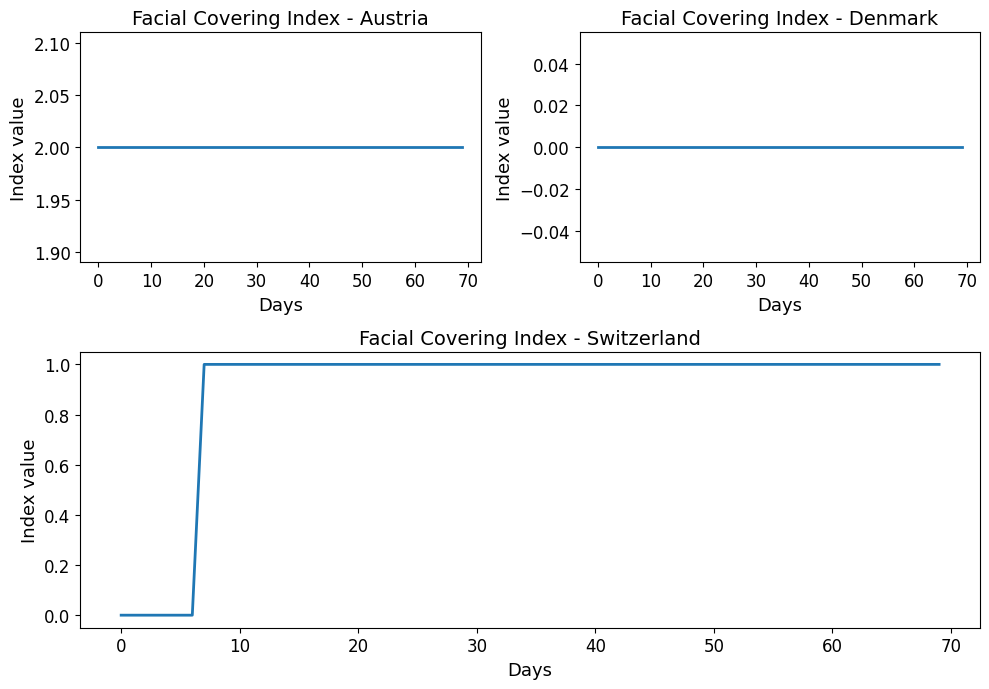

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])

# Austria 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(CHI1, linewidth=2)
ax1.set_title("Facial Covering Index - Austria", fontsize=14)
ax1.set_xlabel("Days", fontsize=13)
ax1.set_ylabel("Index value", fontsize=13)
ax1.tick_params(axis="both", labelsize=12)

# Denmark
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(CHI2, linewidth=2)
ax2.set_title("Facial Covering Index - Denmark", fontsize=14)
ax2.set_xlabel("Days", fontsize=13)
ax2.set_ylabel("Index value", fontsize=13)
ax2.tick_params(axis="both", labelsize=12)

# Switzerland 
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(CHI3, linewidth=2)
ax3.set_title("Facial Covering Index - Switzerland", fontsize=14)
ax3.set_xlabel("Days", fontsize=13)
ax3.set_ylabel("Index value", fontsize=13)
ax3.tick_params(axis="both", labelsize=12)

plt.tight_layout()
plt.savefig("C:/Users/user/Desktop/immaginitt/parte3immagini/FCTOTALETUTTI.png", dpi=300, bbox_inches='tight')
plt.show()

